# LMfit.jl demonstration

2024_10_15: IBS

This notebook demonstrates the current functionality of the `LMfit.jl` package.  This package is patterned after the wonderful `lmfit` python package; I currently implement only a tiny subset of the features of the original Python version: specifically those features that I use...  As I encounter needed features I will move them over.

In general the syntax is similar enough to `lmfit.py`, but owing to differences between Julia and Python, the interface is not identical. 

## Basic setup

In [1]:
using Pkg
if isfile("Project.toml")
    Pkg.activate(".")
end

# Pkg.resolve()
# Pkg.instantiate()

using LaTeXStrings # Because of the l"" syntax
using Revise
using CairoMakie
using LMfit
using LazyGrids

  Activating project at `~/Julia/LMfit/notebooks`


## Direct usage

I am going to start with the most literal possible implementation before introducing convenance features.

We begin by defining an objective function---in this case a simple Gaussian---evaluate the function and generate fake, noisy, data.  Then I plot this to see what we are after.

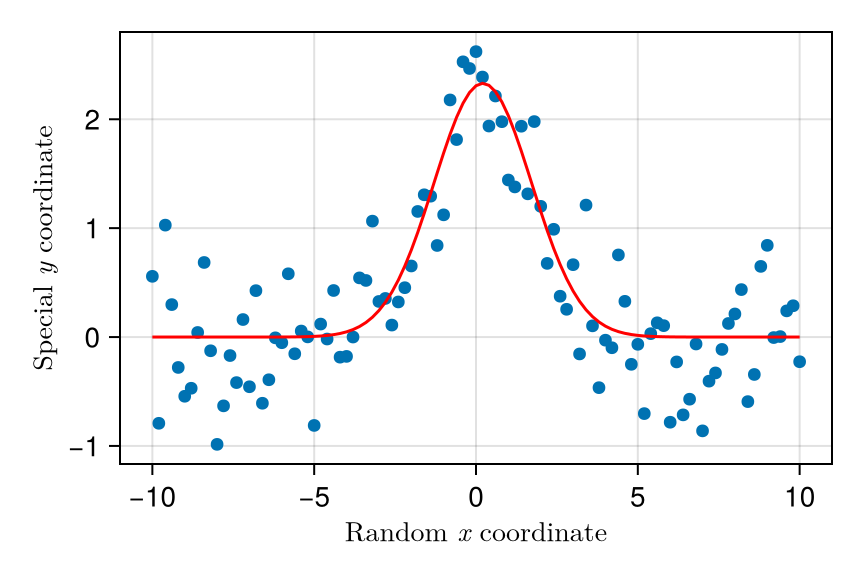

In [2]:
gaussian(x, amp, cen, wid) = @. amp * exp(-(x - cen)^2 / (2 * wid^2))

x = range(-10, 10, length=101)
y = gaussian(x, 2.33, 0.21, 1.51)
y_noise = y .+ 0.5 .* randn(size(x))

f = Figure(size=(6,4).*72)
ax = Axis(f[1,1])
plot!(ax, x, y_noise)
lines!(ax, x, y, color=:red)

ax.xlabel = L"Random $x$ coordinate"
ax.ylabel = L"Special $y$ coordinate"

f

Now we define a model and the associatd parameters

In [5]:
# We are creating a model from the function.  Because of the multiple dispatch system, we need to 
# manually specifiy what args and kwargs are for the specific method we want to use
m  = Model(gaussian, [:x, :amp, :cen, :wid]; var_names=[:x])

# These are the parameters we want to fit
ps = Parameters()
add!(ps, :amp; value=1.0, min=0.0, max=5.0)
add!(ps, :cen; value=0.0, min=-5.0, max=5.0)
add!(ps, :wid; value=1.0)

# Generate data from the model before and after the fit
fm = fit(m, y_noise, ps; x=x)
y_model = m(ps; x=x)
y_fit = m(fm.ps_best; x=x)
println("Final parameters: $(fm.ps_best)")


[1.509013798802876, 2.253811484189662, 0.1916616799652803]
Final parameters: Parameters:
	Parameter: name=wid,	value=1.509013798802876,	min=-Inf,	max=Inf
	Parameter: name=amp,	value=2.253811484189662,	min=0.0,	max=5.0
	Parameter: name=cen,	value=0.1916616799652803,	min=-5.0,	max=5.0



Great!  We have setup the model, linked variables, fit the model, and evaluated the model as a function.  The final stage is to plot the results!

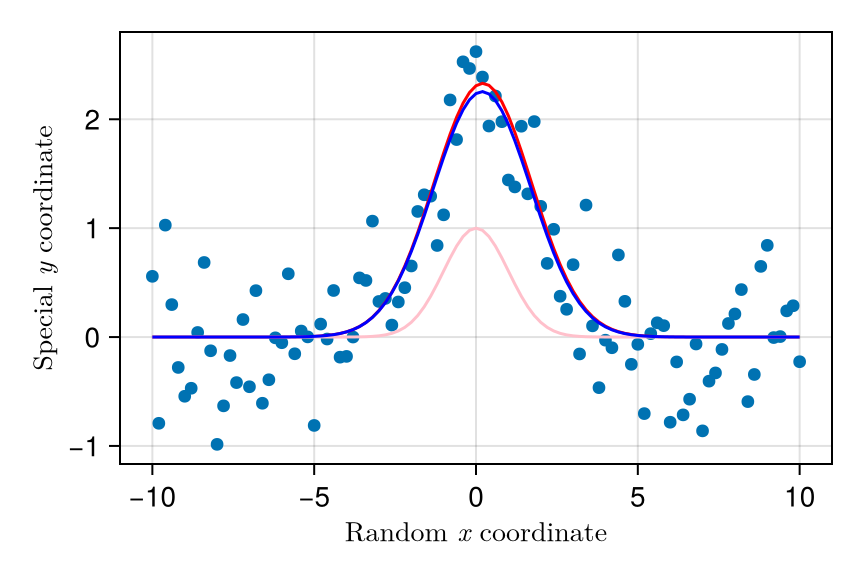

In [6]:
f = Figure(size=(6,4).*72)
ax = Axis(f[1,1])
plot!(ax, x, y_noise)
lines!(ax, x, y, color=:red)
lines!(ax, x, y_model, color=:pink)
lines!(ax, x, y_fit, color=:blue)

ax.xlabel = L"Random $x$ coordinate"
ax.ylabel = L"Special $y$ coordinate"

f

## Simplified usage

When the function is defined locally, the process can be simplified via the `@generate_model` macro.  This works with the function definition to initialize the model.  Notice that this cannot distinguish parameters from independent variables, so we need to specify the variables.  Once the independent variable is defined we can ask the model to automatically generate parameters, but parameters need to be specified. 

In [7]:
# Define an objective function
m = @generate_model gaussian(x, amp, cen, wid) = @. amp * exp(-(x - cen)^2 / (2 * wid^2))
update_vars!(m, :x)

# Create parameters automatically (very little behefit here except for error checking)
ps = make_params(m; amp=(value=1.0, min=0.0, max=5.0), cen=(value=0.0, min=-5.0, max=5.0), wid=1.0)

# Generate data from model
y_model = m(ps; x=x)

# Generate data from the model before and after the fit
fm = fit(m, y_noise, ps; x=x)
y_model = m(ps; x=x)
y_fit = m(fm.ps_best; x=x)
println("Final parameters: $(fm.ps_best)")

[1.509013798802876, 2.253811484189662, 0.1916616799652803]
Final parameters: Parameters:
	Parameter: name=wid,	value=1.509013798802876,	min=-Inf,	max=Inf
	Parameter: name=amp,	value=2.253811484189662,	min=0.0,	max=5.0
	Parameter: name=cen,	value=0.1916616799652803,	min=-5.0,	max=5.0



Great!!  So far I have created a model and the associated parameters, and can evaluate the model for the desired parameters, including a form suitable for fitting.

Next I demonstrate a fit with an algebraic relation

In [10]:
# Define an objective function
m = @generate_model gaussian(x, amp, cen, wid) = @. amp * exp(-(x - cen)^2 / (2 * wid^2))
update_vars!(m, :x)

# Create parameters automatically
ps = make_params(m; amp=2.33, cen=0.21, wid=1.51)
ps[:wid] = Expression(ps[:wid]; expr=:(cen * amp))

# Generate data from the model before and after the fit
fm = fit(m, y_noise, ps; x=x)
y_model = m(ps; x=x)
y_fit = m(fm.ps_best; x=x)
println("Final parameters: $(fm.ps_best)")

[2.4623763979194346, 0.542603715229958, 1.3360945818056467]
Final parameters: Parameters:
	Parameter: name=amp,	value=2.4623763979194346,	min=-Inf,	max=Inf
	Parameter: name=cen,	value=0.542603715229958,	min=-Inf,	max=Inf
	Expression: name=wid,	value=1.3360945818056467,	expr=cen * amp



## Higher dimensional data

One of the most significant motivations for this package is the transparent handling of higher dimensional data.  Let us now consider fitting to a 2D Gaussian, and as before I will start by creating the noisy data to fit to.

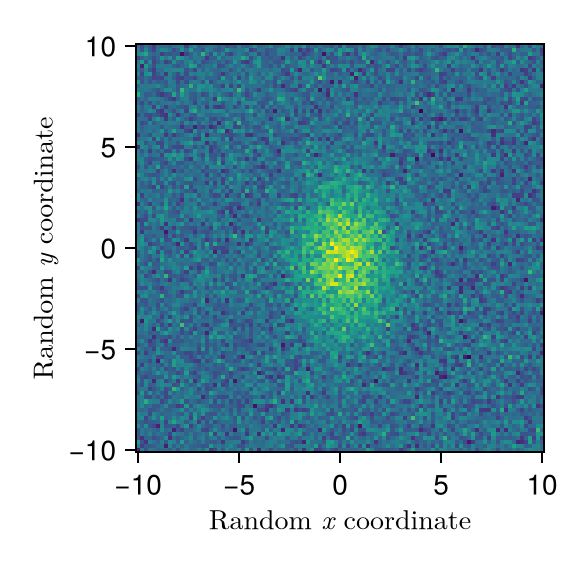

In [11]:
# Define an objective function
m = @generate_model gaussian2D(x, y, amp, cen_x, cen_y, wid_x, wid_y) = @. amp * exp(-(x - cen_x)^2 / (2 * wid_x^2)-(y - cen_y)^2 / (2 * wid_y^2) )

x = range(-10, 10, length=101)
y = range(-10, 10, length=101)
(xgrid, ygrid) = ndgrid(x, y) # using LazyGrids

z = gaussian2D(xgrid, ygrid, 2.33, 0.21, -0.5, 1.51, 2.5)
z_noise = z .+ 0.5 .* randn(size(xgrid))

f = Figure(size=(4,4).*72)
ax = Axis(f[1,1], aspect=1)
heatmap!(ax, x, y, z_noise)

ax.xlabel = L"Random $x$ coordinate"
ax.ylabel = L"Random $y$ coordinate"

f

In [12]:
update_vars!(m, :x, :y)

# These are the parameters we want to fit
ps = Parameters()
add!(ps, :amp; value=1.0, min=0.0, max=5.0)
add!(ps, :cen_x; value=0.0, min=-5.0, max=5.0)
add!(ps, :cen_y; value=0.0, min=-5.0, max=5.0)
add!(ps, :wid_x; value=1.0)
add!(ps, :wid_y; value=1.0)

# Generate data from the model before and after the fit
fm = fit(m, z_noise, ps; x=xgrid, y=ygrid)
z_model = m(ps; x=xgrid, y=ygrid)
z_fit = m(fm.ps_best; x=xgrid, y=ygrid)
println("Final parameters: $(fm.ps_fit)")

[-0.5251345284093355, 2.477903044679554, 1.538811494591411, 0.2031259507582224, 2.3375062351261384]


UndefVarError: UndefVarError: `ps_fit` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Since it is difficult to plot curves through data for 2D data, I will instead show the residuals.  This also serves to highlight the provided `residuals` function.

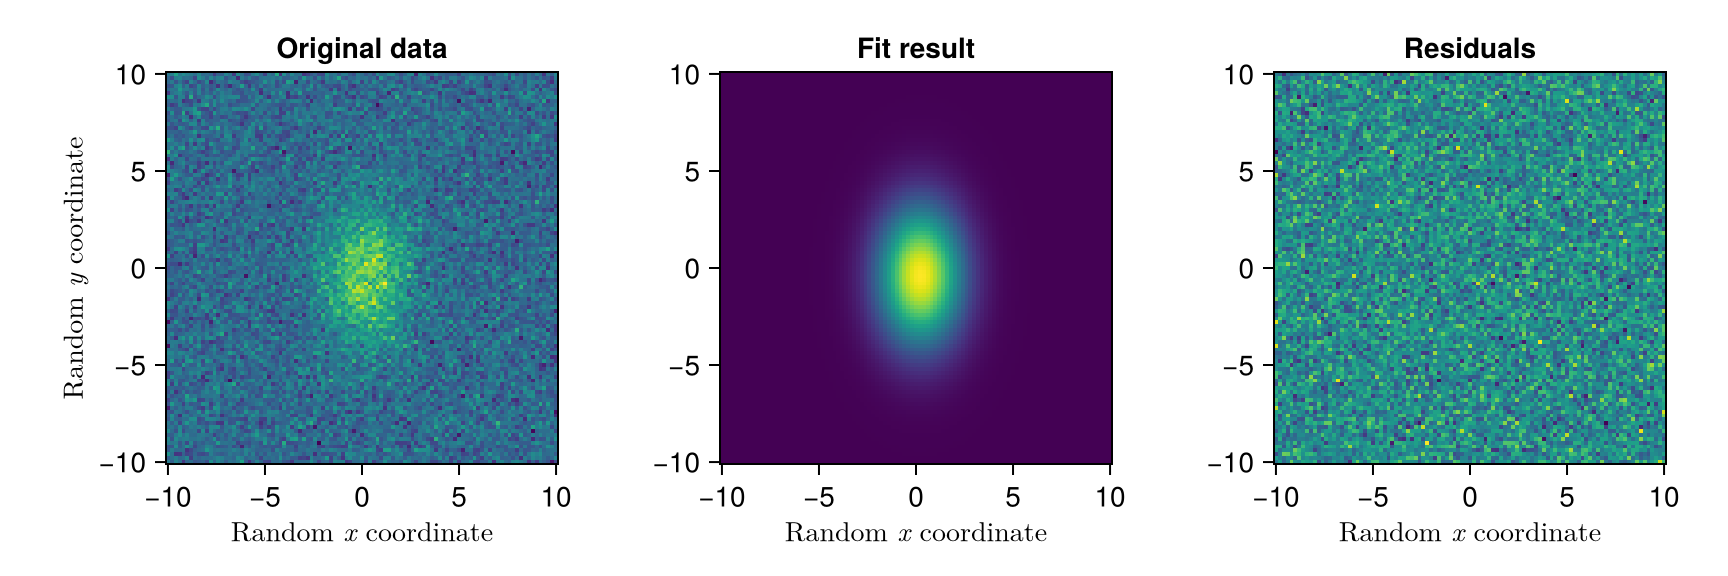

In [23]:
f = Figure(size=(12,4).*72)
ax = Axis(f[1,1], aspect=1, title="Original data")
heatmap!(ax, x, y, z_noise)

ax.xlabel = L"Random $x$ coordinate"
ax.ylabel = L"Random $y$ coordinate"

ax = Axis(f[1, 2], aspect=1, title="Fit result")
heatmap!(ax, x, y, z_fit)

ax.xlabel = L"Random $x$ coordinate"

ax = Axis(f[1, 3], aspect=1, title="Residuals")
heatmap!(ax, x, y, residuals(fm) )

ax.xlabel = L"Random $x$ coordinate"

f

## Scratch

I am currently extending this to work with vectors as well (or anything that iterates and can be changed)

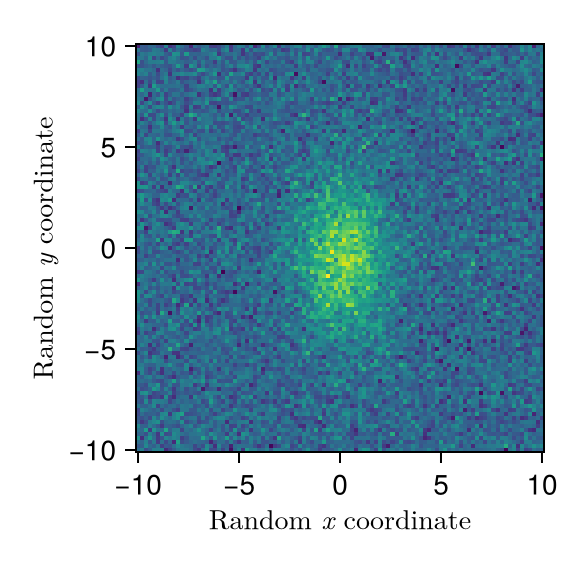

In [48]:
# Define an objective function
m = @generate_model gaussian2D(x, y, amp, cen, wid) = @. amp * exp(-(x - cen[1])^2 / (2 * wid[1]^2)-(y - cen[2])^2 / (2 * wid[2]^2) )

x = range(-10, 10, length=101)
y = range(-10, 10, length=101)
(xgrid, ygrid) = ndgrid(x, y) # using LazyGrids

z = gaussian2D(xgrid, ygrid, 2.33, [0.21, -0.5], [1.51, 2.5])
z_noise = z .+ 0.5 .* randn(size(xgrid))

f = Figure(size=(4,4).*72)
ax = Axis(f[1,1], aspect=1)
heatmap!(ax, x, y, z_noise)

ax.xlabel = L"Random $x$ coordinate"
ax.ylabel = L"Random $y$ coordinate"

f

In [50]:
update_vars!(m, :x, :y)

# These are the parameters we want to fit
ps = Parameters()
add!(ps, :amp; value=1.0, min=0.0, max=5.0)
add!(ps, :cen; value=[0.0,0.0], min=[-5.0, -5], max=[5.0, 5.0])
add!(ps, :wid; value=[1.0, 1.0])

# Generate data from the model before and after the fit
fm = fit(m, z_noise, ps; x=xgrid, y=ygrid)

[1.5018055432085988, 2.5942789721968778, 2.3190035161570455, 0.1628609736888863, -0.46997845208316186]


MethodError: MethodError: Cannot `convert` an object of type Float64 to an object of type Vector{Float64}
The function `convert` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  convert(::Type{Array{T, N}}, !Matched::StaticArraysCore.SizedArray{S, T, N, N, Array{T, N}}) where {S, T, N}
   @ StaticArrays ~/.julia/packages/StaticArrays/MSJcA/src/SizedArray.jl:88
  convert(::Type{Array{T, N}}, !Matched::StaticArraysCore.SizedArray{S, T, N, M, TData} where {M, TData<:AbstractArray{T, M}}) where {T, S, N}
   @ StaticArrays ~/.julia/packages/StaticArrays/MSJcA/src/SizedArray.jl:82
  convert(::Type{T}, !Matched::T) where T
   @ Base Base.jl:126
  ...


In [ ]:

z_model = m(ps; x=xgrid, y=ygrid)
z_fit = m(fm.ps_best; x=xgrid, y=ygrid)
println("Final parameters: $(ps_fit)")

In [106]:
ps = Parameters()
add!(ps, :amp; value=[1.0, 2.0], min=[0.0,0.0], max=[5.0, 5.0])
add!(ps, :width; value=[2.0, 3.0], min=[0.0,0.0], max=[5.0, 5.0])
LMfit.resolve_parameters(ps)

#203 (generic function with 1 method)

In [37]:
Int <: Number

true

In [82]:
LMfit.resolve_parameters

resolve_parameters (generic function with 1 method)